This project explores stock data forecasting and trading strategies that make use of that forecast.

The intent is not to create some production ready trading strategy, but to showcase some popular time series statistical models (ARIMA, SARIMAX, Simple Exponential Smoothing), how to train them, and how to use the forecasts in real strategies using the Backtrader library. I have also made use of technical analysis tools like Bollinger Bands.

# Imports

In [1]:
from abc import ABC, abstractmethod
import operator
from typing import Optional, Tuple, TypeVar
import warnings

from backtrader_plotly.plotter import BacktraderPlotly
from backtrader_plotly.scheme import PlotScheme
import numpy as np
import pandas as pd
import pmdarima as pm
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import quantstats
from scipy import signal
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm


pyo.init_notebook_mode()
warnings.simplefilter('ignore', ConvergenceWarning)

# Utility functions

## Loading data

In [2]:
def read_sheet(sheet_name):
    def parse_volume(volume_string):
        unit = volume_string[-1]
        try:
            quantity = float(volume_string[:-1])
        except ValueError:
            return 0
            
        if unit == "M":
            return quantity
        elif unit == "K":
            return quantity / 1000

            
    df = (
        pd.read_excel(xlsx, sheet_name)
        .iloc[:-1]
        .astype({"Price": float, "Open": float, "High": float, "Low": float})
        .set_index("Date")
        .sort_index(ascending=True)
    )
    df["Volume"] = df["Vol."].map(parse_volume)
    df.index = df.index.to_period('D')
    return df

## Plotting

In [3]:
def plot_candlesticks(ohlcv: pd.DataFrame):
    fig = go.Figure(data=[go.Candlestick(
        x=ohlcv.index.to_timestamp(),
        open=ohlcv['Open'],
        high=ohlcv['High'],
        low=ohlcv['Low'],
        close=ohlcv["Price"]
    )])

    fig.update_layout(height=500, xaxis_rangeslider_visible=False)
    return fig


def plot_forecast(signal_train, signal_test, forecast):
    return go.Figure(
        data=[
            go.Scatter(x=signal_train.index.to_timestamp(), y=signal_train, name="Train data", line_color="green"),
            go.Scatter(x=signal_test.index.to_timestamp(), y=signal_test, name="Test data", line_color="red"),
            go.Scatter(x=signal_test.index.to_timestamp(), y=forecast, name="Forecast", line_color="blue"),
        ],
        layout=dict(height=500)
    )


def show_movements(cerebro, plot_tomorrow_forecast=False):
    scheme = PlotScheme(decimal_places=5, max_legend_text_width=16)
    fig = cerebro.plot(BacktraderPlotly(show=False, scheme=scheme))[0][0]
    if plot_tomorrow_forecast:
        tomorrow_forecast = go.Scatter(x=strategy.exported["datetime"], y=strategy.exported["forecasted"], name="Tomorrow forecast")
        fig.add_trace(tomorrow_forecast, row=3, col=1, secondary_y=True)
    return fig

## Modeling

In [4]:
T = TypeVar('T', bound='TimeSeriesModel')


class TimeSeriesModel(ABC):
    def __init__(self):
        self.history = None
        
    @abstractmethod
    def fit(self: T, history: pd.Series, exog: Optional[pd.Series] = None) -> T:
        """
        Fits the model onto the history time series as training data.
        :return: the same TimeSeriesModel instance
        :rtype: :class:`TimeSeriesModel`
        """
        self.history = history
        return self

    @abstractmethod
    def update(self: T, value) -> T:
        """
        Fits the model adding the new value to the history
        :return: the same TimeSeriesModel instance
        :rtype: :class:`TimeSeriesModel`
        """

    @abstractmethod
    def forecast(self, exog=None) -> float:
        """
        Forecast next value in time series
        """


class StatsmodelsTimeSeriesModelWrapper(TimeSeriesModel):
    def __init__(self, model_class, use_exogenous=True, **hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.use_exogenous = use_exogenous
        self.model = None
        self.history = None
        self.exogenous = None

    def __getattr__(self, attr):
        if self.model is not None:
            return getattr(self.model, attr)
    
    def fit(self, history, exog=None):
        if exog is not None and self.use_exogenous:
            self.model = self.model_class(history, exog=exog, **self.hyperparameters).fit()
        else:
            self.model = self.model_class(history, **self.hyperparameters).fit()
        self.history = history
        self.exogenous = exog
        return self

    def update(self, value, exog=None):
        new_history = np.concatenate((self.history, np.array([value])))
        if exog is not None and self.use_exogenous:
            new_exogenous = np.concatenate((self.exogenous, np.array([exog])))
        else:
            new_exogenous = None
        self.fit(new_history, new_exogenous)

    def forecast(self, exog=None):
        if exog is not None and self.use_exogenous:
            return self.model.forecast(exog=np.array(exog).reshape((-1, 1)))
        else:
            return self.model.forecast()


class AutoArimaWrapper(TimeSeriesModel):
    def __init__(self, use_exogenous=True, **hyperparameters):
        self.hyperparameters = hyperparameters
        self.use_exogenous = use_exogenous
        self.model = None

    def __getattr__(self, attr):
        if self.model is not None:
            return getattr(self.model, attr)
    
    def fit(self, history, exog=None):
        if exog is not None and self.use_exogenous:
            self.model = pm.auto_arima(
                history,
                exog.values.reshape((-1, 1)),
                **self.hyperparameters
            )
        else:
            self.model = pm.auto_arima(
                history,
                **self.hyperparameters
            )
        return self

    def update(self, value, exog=None):
        if exog is not None and self.use_exogenous:
            return self.model.update(value, X=np.array(exog).reshape(1, -1))

    def forecast(self, exog=None):
        if exog is not None and self.use_exogenous:
            return self.model.predict(n_periods=1, X=np.array(exog).reshape((-1, 1)))
        else:
            return self.model.predict(n_periods=1)

        
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print(f"pvalue: {pvalue}")
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

## Forecasting

In [5]:
def time_series_rolling_forecast(model: TimeSeriesModel, train, test, exog_train=None, exog_test=None):    
    predictions = []

    exog_test_iterable = exog_test if exog_test is not None else [None] * len(test)

    if exog_train is not None:
        model.fit(train, exog=exog_train)
    else:
        model.fit(train)
    
    for value, exog in tqdm(zip(test, exog_test_iterable), total=len(test), desc="Rolling forecast", leave=False):
        forecast = model.forecast(exog=exog)
        model.update(value, exog=exog)
        predictions.append(forecast[0])
            
    return pd.Series(predictions)


## Evaluation

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return ((y_pred - y_true).abs().sum() / y_true.sum()) * 100


def get_sign_accuracy(y_true, y_pred):
    true_sign = pd.Series(y_true).diff().iloc[1:] > 0
    pred_sign = pd.Series(y_pred).diff().iloc[1:] > 0

    return (true_sign == pred_sign).mean()


def show_results(train_series, test_series, forecasted_series):
    mape = mean_absolute_percentage_error(test_series.values, forecasted_series)
    fig = plot_forecast(train_series, test_series, forecasted_series)
    fig.update_layout(title=f"MAPE: {mape:.2f}")
    return fig


def get_strategy_returns(strategy):
    pyfolio_analysis = strategy.analyzers.getbyname("PyFolio")
    returns, positions, transactions, gross_lev = pyfolio_analysis.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    return returns
    

def get_strategy_stats(strategy):
    returns = get_strategy_returns(strategy)
    return {
        'Sharpe Ratio': quantstats.stats.sharpe(returns),
        "Profit": quantstats.stats.comp(returns),
        "Max Drawdown": quantstats.stats.max_drawdown(returns)
    }


def plot_strategy_result(strategy):
    returns = get_strategy_returns(strategy)
    return quantstats.plots.snapshot(returns)


def get_optimum_parameters(cerebro_run):
    optimization_results = [
        dict(
            parameters=vars(strategy.params),
            stats=get_strategy_stats(strategy)
        )
        for iteration in cerebro_run
        for strategy in iteration
    ]
        
    best_result = max(optimization_results, key=lambda results: results["stats"]["Profit"])
    # best_index = optimization_results.index(best_result)

    return best_result["parameters"]

# Load data

In [7]:
data_file = "2020Q1Q2Q3Q4-2021Q1.xlsx"
xlsx = pd.ExcelFile(data_file)
sheet_names = xlsx.sheet_names

dfs = {
    sheet: read_sheet(sheet)
    for sheet in xlsx.sheet_names
}

In [8]:
sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

# Stock A

## Exploring

In [9]:
df = dfs[sheet_names[0]]

In [10]:
plot_candlesticks(df)

### Check for stationarity to find the differentiation order

### Find D order

In [11]:
check_stationarity(df.Price)

pvalue: 0.7582066363876823
The series is NOT stationary


In [12]:
check_stationarity(df.Price.diff().dropna())

pvalue: 4.6146668027327283e-07
The series is stationary


It seems the order is D=1

In [13]:
price_diff = df.Price.diff().fillna(0)

In [14]:
fig = px.line(price_diff.values)
fig.update_layout(height=500)

### Find AR and MA orders

For the differenced stock price, we can plot the autocorrelation and the partial autocorrelation to find the p (autoregressive) and q (moving average) parameters.

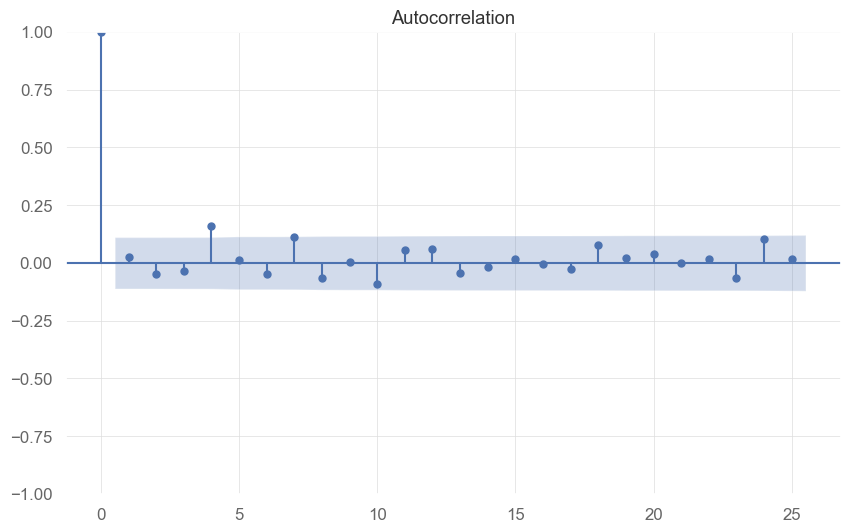

In [15]:
plot_acf(price_diff);
plot_pacf(price_diff);

From a visual inspection, we do not see any significant dependence of the change signal with previous samples.
In any case, we could set P=4 and Q=4 since there seems to be a coefficient in there.

### Check for seasonal component

Let's find first an estimation for the period. The trend is clearly 0, so we can take a look at the spectrum

In [16]:
window = signal.windows.hamming(price_diff.size)
price_diff_windowed = price_diff * window
freq, power_spectral_density = signal.periodogram(price_diff_windowed)
go.Figure(
    go.Scatter(x=freq, y=power_spectral_density),
    layout=dict(height=500)
)

We find two really pronounced peaks at frequencies 0.1 and 0.33, indicating possible periodicities for seasonality of 10 days and 3 days respectively. However there is a lot of noise, so I am not clear that adding this seasonality would be of any help.

In [17]:
result = seasonal_decompose(price_diff.values, model="additive", period=10)
result.plot();

The seasonal component for a period of 10 samples has an amplitude of 1, which is not too much taking in account that the amplitude of the signal is around 20.
Let's examine its autocorrelation and partial autocorrelation:

pvalue: 0.0
The series is stationary


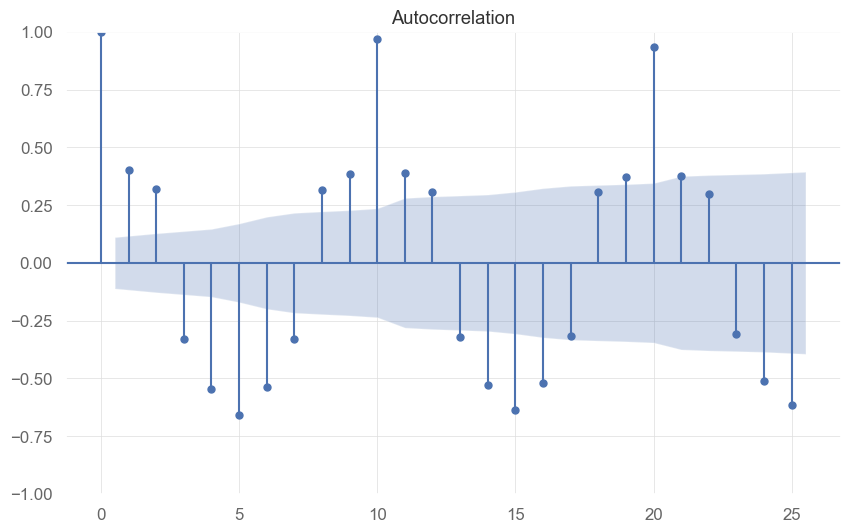

In [18]:
seasonal = result.seasonal
check_stationarity(seasonal)
plot_acf(seasonal);
plot_pacf(seasonal);

## Modeling

In [19]:
is_train = df.index.year < 2021
df_train = df[is_train]
df_test = df[~is_train]

### ARIMA

In [20]:
AR_order = 4
differentiation_order = 1
MA_order = 0

arima_wrapper = StatsmodelsTimeSeriesModelWrapper(ARIMA, order=(AR_order, differentiation_order, MA_order))

forecast_arima = time_series_rolling_forecast(
    arima_wrapper,
    df_train.Price,
    df_test.Price
)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

In [21]:
show_results(df_train.Price, df_test.Price, forecast_arima)

In [22]:
AR_order = 4
differentiation_order = 1
MA_order = 2

arima_wrapper = StatsmodelsTimeSeriesModelWrapper(ARIMA, order=(AR_order, differentiation_order, MA_order))

forecast_arima = time_series_rolling_forecast(
    arima_wrapper,
    df_train.Price,
    df_test.Price
)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

In [23]:
show_results(df_train.Price, df_test.Price, forecast_arima)

### SARIMA

In [24]:
sarimax_wrapper = StatsmodelsTimeSeriesModelWrapper(
    SARIMAX,
    order=(AR_order, differentiation_order, MA_order),
    seasonal_order=(1,0,0,10),
    enforce_stationarity=False
)
        
forecast_sarima = time_series_rolling_forecast(
    sarimax_wrapper,
    df_train.Price,
    df_test.Price
)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

In [25]:
show_results(df_train.Price, df_test.Price, forecast_sarima)

### SARIMAX

In [26]:
volume = df["Vol."].map(lambda volume: float(volume.rstrip("M")))
volume_previous_day = volume.shift().bfill()
volume_train_previous_day = volume_previous_day[is_train]
volume_test_previous_day = volume_previous_day[~is_train]

In [27]:
AR_order = 1
differentiation_order = 0
MA_order = 0

sarimax_wrapper = StatsmodelsTimeSeriesModelWrapper(
    SARIMAX,
    order=(AR_order, differentiation_order, MA_order),
    enforce_stationarity=False
)

forecast_sarimax = time_series_rolling_forecast(
    sarimax_wrapper,
    df_train.Price,
    df_test.Price,
    exog_train=volume_train_previous_day,
    exog_test=volume_test_previous_day
)

show_results(df_train.Price, df_test.Price, forecast_sarimax)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

### Automatic setting of model parameters (AutoArima)

In [28]:
model_autoarima = AutoArimaWrapper(
    start_p=1, 
    start_q=1,
    m=10,
    suppress_warnings=False
)

forecast_autoarima = time_series_rolling_forecast(model_autoarima, df_train.Price, df_test.Price, volume_train_previous_day, volume_test_previous_day)

show_results(df_train.Price, df_test.Price, forecast_autoarima)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

### Exponential Smoothing

In [29]:
model_ses = StatsmodelsTimeSeriesModelWrapper(SimpleExpSmoothing)
forecast_ses = time_series_rolling_forecast(model_ses, df_train.Price, df_test.Price)
show_results(df_train.Price, df_test.Price, forecast_ses)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

The optimized smoothing parameter value is practically 1, which means the algorithm found all meaningful information for predicting today's price is yesterday's price.

Let's try now with the change in price:

In [30]:
price_diff = df.Price.diff().fillna(0)
price_diff_train = price_diff[is_train]
price_diff_test = price_diff[~is_train]

In [31]:
forecast_ses_change = time_series_rolling_forecast(model_ses, price_diff_train, price_diff_test)
show_results(price_diff_train, price_diff_test, forecast_ses_change)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

The algorithm can conclude nothing with the difference of price:

In [32]:
model_ses.params

{'smoothing_level': 1.4901161193847656e-08,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

We can try to add trend prediction to see if it helps

In [33]:
model_exps = StatsmodelsTimeSeriesModelWrapper(ExponentialSmoothing, trend="add")
forecast_exps = time_series_rolling_forecast(model_exps, df_train.Price, df_test.Price)
show_results(df_train.Price, df_test.Price, forecast_exps)


Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

# All signals

Now we apply the AutoARIMA and SimpleExpSmoothing to all signals and calculate their MAPE:

In [34]:
def process_signal(stock_data: pd.DataFrame, model: TimeSeriesModel):
    def parse_volume(volume_string):
        unit = volume_string[-1]
        try:
            quantity = float(volume_string[:-1])
        except ValueError:
            return 0
            
        if unit == "M":
            return quantity
        elif unit == "K":
            return quantity / 1000
    
    def train_test_split(x):
        is_train = x.index.year < 2021
        return x[is_train], x[~is_train]
    
    price = stock_data["Price"]
    volume = stock_data["Vol."].map(parse_volume)
    volume_previous_day = volume.shift().bfill()
    
    price_train, price_test = train_test_split(price)
    volume_train_previous_day, volume_test_previous_day = train_test_split(volume_previous_day)
    
    forecast = time_series_rolling_forecast(model, price_train, price_test, volume_train_previous_day, volume_test_previous_day)
    mape = mean_absolute_percentage_error(price_test.values, forecast)
    sign_accuracy = get_sign_accuracy(price_test.values, forecast)
    
    fig = show_results(price_train, price_test, forecast);

    return model.summary(), forecast, mape, sign_accuracy, fig

In [35]:
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')


model_autoarima = AutoArimaWrapper(
    start_p=1, 
    start_q=1,
    suppress_warnings=False
)

model_ses = StatsmodelsTimeSeriesModelWrapper(SimpleExpSmoothing, use_exogenous=False)

models = dict(autoarima=model_autoarima, ses=model_ses)

results = defaultdict(dict)
pbar = tqdm(dfs.items())
for sheet, df in pbar:
    pbar.set_description(f"Sheet: {sheet}")
    for name, model in tqdm(models.items(), desc="Models", leave=False):
        results[sheet][name] = process_signal(df, model)

  0%|          | 0/8 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/63 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/63 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/69 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/69 [00:00<?, ?it/s]

In [36]:
mapes = pd.DataFrame(results).T.applymap(lambda x: x[2])

mapes_baseline = {
    stock: mean_absolute_percentage_error(data.Price, data.Price.shift(-1))
    for stock, data in dfs.items()
}

mapes["Baseline"] = pd.Series(mapes_baseline)

mapes_plot = mapes.rename_axis(columns="Model", index="Stock").stack().rename("Mape").reset_index()
mapes_plot.Model = mapes_plot.Model.map(str)

px.bar(
    mapes_plot,
    x="Stock",
    y="Mape",
    color="Model",
    barmode="group",
    height=500,
)

The results show that these models perform just slightly better than just taking today's price to predict tomorrow's price.

We can take a look at the accuracy at predicting whether the price is going to go up or down. As we can see, these models are not even useful for that in the case of stock data.

In [37]:
sign_accuracies = pd.DataFrame(results).T.applymap(lambda x: x[3])
sign_accuracies

autoarima       ses
Russia - Sberbank Rossii PAO (S   0.433333  0.416667
Turkey - Koc Holding AS (KCHOL)   0.548387  0.532258
Egypt - Medinet Nasr Housing (M   0.524590  0.442623
Brazil - Minerva SABrazil (BEEF   0.508475  0.491525
Argentina - Pampa Energia SA (P   0.423729  0.440678
Colombia - Cementos Argos SA (C   0.550000  0.566667
South Africa - Impala Platinum    0.311475  0.295082
South Korea - Dongkuk Steel Mil   0.514706  0.544118

In [38]:
sign_accuracies.mean()

autoarima    0.476837
ses          0.466202
dtype: float64

# Testing strategies

The strategy we are going to use is based on Bollinger Bands. Basically, the moment the predicted price for next day goes below the bottom Bollinger band, a buy signal is generated. Then, when the price arrives to the moving average, the position is closed (the shares are sold). The opposite will happen when the price goes above the top Bollinger Band.

In each movement, we always invest almost all the capital (10000 dollars at the beginning) since we buy the maximum number of shares we can in each movement. This will allow for compound interest to emerge.

The model used to make the prediction of next day's price is a Simple Exponential Smoothing.

First we define the strategy:

In [62]:
import logging

import backtrader as bt
from IPython.core.debugger import set_trace


logging.getLogger().setLevel(logging.INFO)


class CSVData(bt.feeds.PandasData):
    lines = ("close",)
    params = (("close", "Price"),)


order_status_to_string = ["Created", "Submitted", "Accepted", "Partial", "Completed", "Canceled", "Expired", "Margin", "Rejected"]


class BollingerBandStrategy(bt.Strategy):
    params = (
        ('period', 20),  # period for the Bollinger Bands
        ('devfactor', 2.0),  # number of standard deviations for the Bollinger Bands
        ("enable_log", True),
        ("min_hold_days", 1),
        ("start_day", pd.Timestamp("2021-01-01")),
        ("short_position_allowed", False), 
    )

    def __init__(self):
        self.bband = bt.indicators.BollingerBands(self.data.close, period=self.params.period, devfactor=self.params.devfactor)
        self.predictor = StatsmodelsTimeSeriesModelWrapper(SimpleExpSmoothing, use_exogenous=False)

        self.exported = {"datetime": [], "forecasted": []}

    def next(self):
        def max_shares_to_buy(price):
            cash = self.broker.getcash()
            return (cash / 2) // price

        def is_time_to_close_position():
            """Close the position if yesterday's price arrived to the moving average (midpoint of Bollinger Bands)"""
            need_to_hold_more_days = len(self) < (self.bar_executed + self.params.min_hold_days)
            crossed_moving_average_from_bottom = self.position.size > 0 and self.data.close[0] > self.bband.lines.mid[0]
            crossed_moving_average_from_top = self.position.size < 0 and self.data.close[0] < self.bband.lines.mid[0]

            crossed_top_band = self.position.size > 0 and self.data.close[0] > self.bband.lines.top[0]
            crossed_bottom_band = self.position.size < 0 and self.data.close[0] < self.bband.lines.bot[0]
            
            return (not need_to_hold_more_days) and (crossed_top_band or crossed_bottom_band)
                
        if self.data.datetime.datetime() < self.params.start_day:
            return

        close_prices = np.array(self.data.close.array)[:len(self)]
        self.predictor.fit(close_prices)
        tomorrow_forecast = self.predictor.forecast()[0]
        self.exported["forecasted"].append(tomorrow_forecast)
        self.exported["datetime"].append(self.data.datetime.datetime())
        
        if self.position:
            if is_time_to_close_position():
                self.close()
        else:
            self._log(f"""
                Date: {self.data.datetime.datetime()}
                Today Price: {self.data.close[0]}
                Yesterday Price: {self.data.close[-1]}
                Last Price array: {close_prices[-1]}
                Tomorrow forecast: {tomorrow_forecast}
                Bottom bband: {self.bband.lines.bot[0]}
                """)
            if tomorrow_forecast < self.bband.lines.bot[0]:
                self._log("Buy")
                self._log(f"""
                Date: {self.data.datetime.datetime()}
                Today Price: {self.data.close[0]}
                Yesterday Price: {self.data.close[-1]}
                Last Price array: {close_prices[-1]}
                Tomorrow forecast: {tomorrow_forecast}
                Tomorrow real price: {self.data.close[1]}
                """)
                self.buy(size=max_shares_to_buy(tomorrow_forecast))
            elif self.params.short_position_allowed and tomorrow_forecast > self.bband.lines.top[0]:
                self._log("Sell")
                self.sell(size=max_shares_to_buy(tomorrow_forecast))
            
    def notify_order(self, order):
        self._log(f"order status: {order_status_to_string[order.status]}")
        
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status == order.Completed:
            self.bar_executed = len(self)
    
        self.order = None

    def _log(self, message):
        if not self.params.enable_log:
            return
            
        current_date = self.datas[0].datetime.date(0)
        logging.info(f"logging {current_date}. {message}")


Run the strategy over all stocks

In [63]:
from typing import Type


DEFAULT_CASH = 100000.0


def run_strategy(data: pd.DataFrame, strategy: Type[bt.Strategy], **strategy_parameters):
    cerebro = bt.Cerebro()
    data = data.copy()
    data.index = data.index.to_timestamp()
    data_feed = CSVData(dataname=data, fromdate=pd.Timestamp("2020-10-01"))
    cerebro.adddata(data_feed)
    cerebro.broker.setcash(DEFAULT_CASH)
    
    cerebro.addstrategy(
        BollingerBandStrategy,
        **strategy_parameters
    )
    # cerebro.broker.setcommission(commission=0.00, margin=1e-15)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    
    strategy, *_ = cerebro.run()
    return strategy, cerebro


runs = {
    stock: run_strategy(data, BollingerBandStrategy, enable_log=False)
    for stock, data in dfs.items()
}

stats = {
    stock: get_strategy_stats(strategy)
    for stock, (strategy, cerebro) in runs.items()
}

df_stats = pd.DataFrame(stats).T

go.Figure(
    data=[
        go.Bar(x=df_stats.index, y=df_stats["Profit"] * DEFAULT_CASH, name="Profit"),
        go.Bar(x=df_stats.index, y=df_stats["Max Drawdown"] * DEFAULT_CASH, name="Max Drawdown")
    ],
    layout=dict(
        height=500,
        yaxis_title="Dollars"
    )
)

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide



We can see how in most of stocks, the algorithm did not find any good moment for buying, and the profit is, in general, not too good. It seems there is more risk of loosing a high quantity of money than earning a high quantity.

We can look to the detailed graphs next:

Russia - Sberbank Rossii PAO (S
{'Sharpe Ratio': 1.9405953746238696, 'Profit': 0.04188099999999961, 'Max Drawdown': -0.019687448996246304}


Turkey - Koc Holding AS (KCHOL)
{'Sharpe Ratio': 2.0035630997568545, 'Profit': 0.11227369999999914, 'Max Drawdown': -0.035657409205671176}


Egypt - Medinet Nasr Housing (M
{'Sharpe Ratio': -0.020330722650832595, 'Profit': -0.0013476999999998407, 'Max Drawdown': -0.04980308794588206}


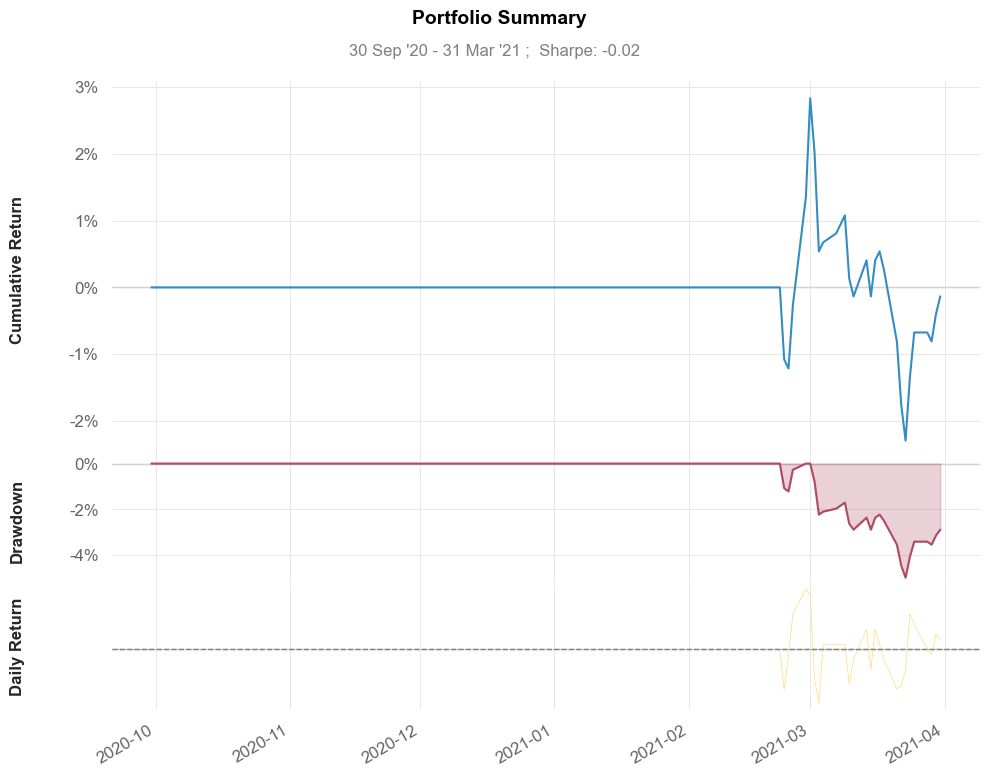

Brazil - Minerva SABrazil (BEEF
{'Sharpe Ratio': nan, 'Profit': 0.0, 'Max Drawdown': 0.0}


C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide



C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide



Argentina - Pampa Energia SA (P
{'Sharpe Ratio': nan, 'Profit': 0.0, 'Max Drawdown': 0.0}


C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide



C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide



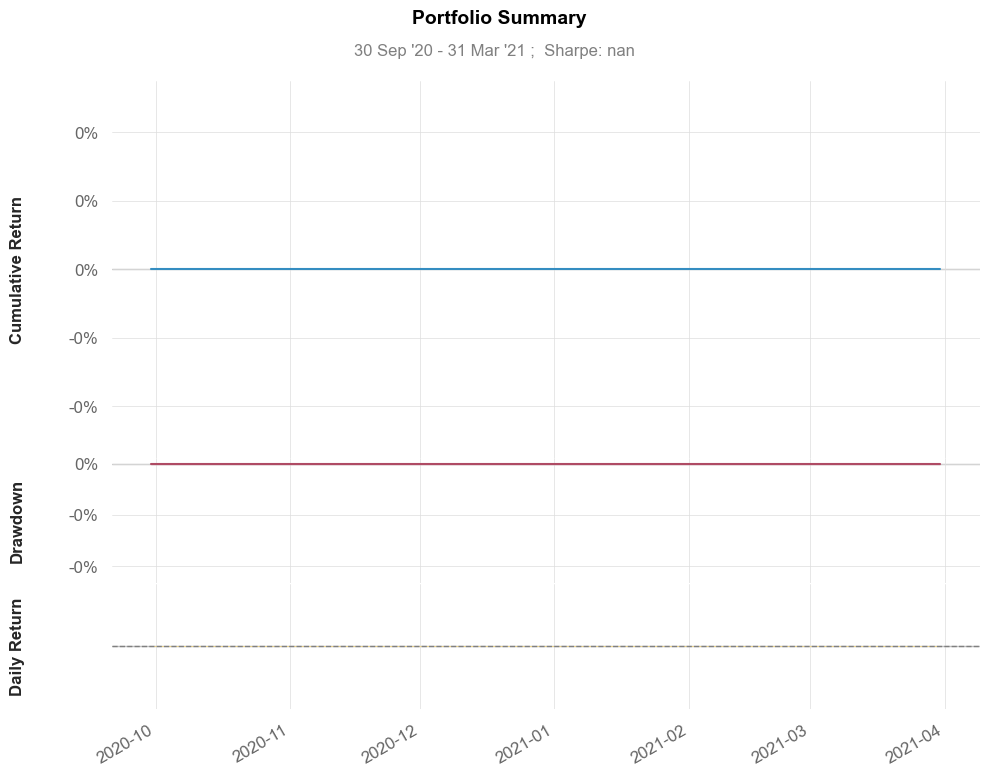

Colombia - Cementos Argos SA (C
{'Sharpe Ratio': -1.6403626728367342, 'Profit': -0.03599999999999981, 'Max Drawdown': -0.06000000000000005}


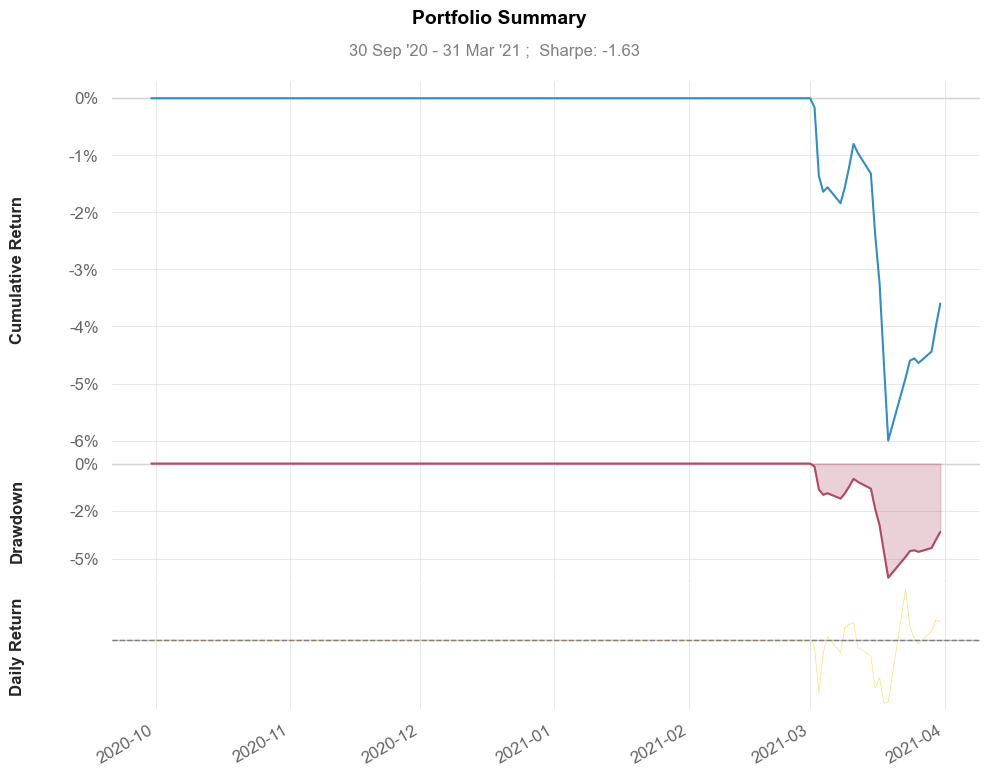

South Africa - Impala Platinum 
{'Sharpe Ratio': nan, 'Profit': 0.0, 'Max Drawdown': 0.0}


C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide



C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide



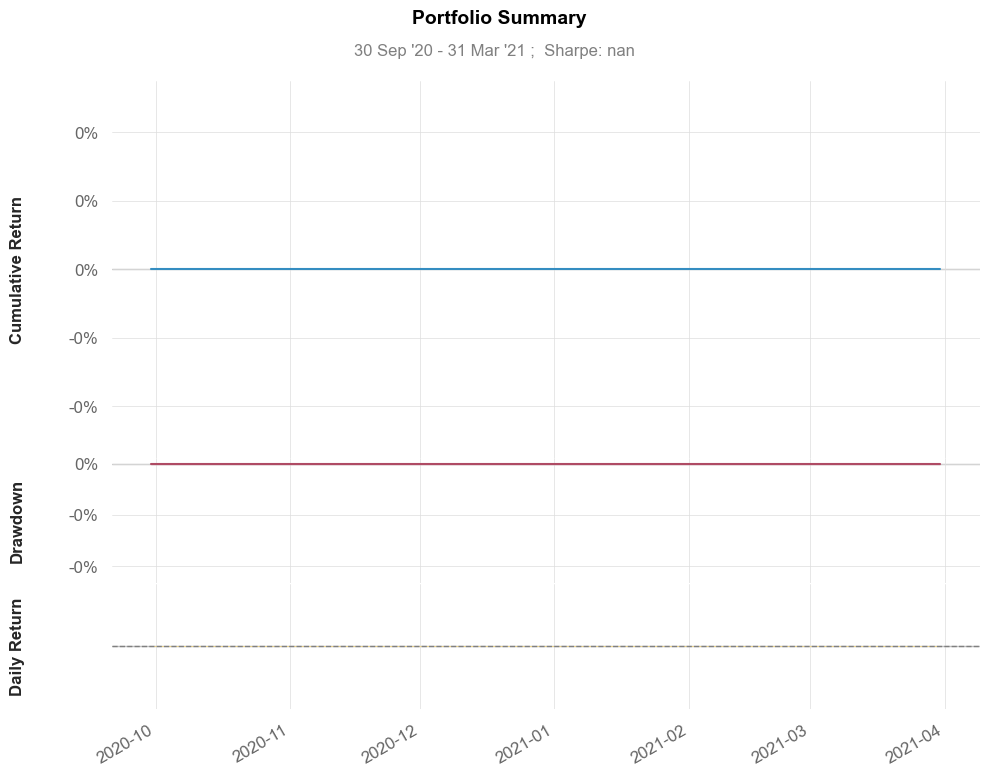

South Korea - Dongkuk Steel Mil
{'Sharpe Ratio': 1.3481812676218237, 'Profit': 0.06479999999999952, 'Max Drawdown': -0.01893649579188983}


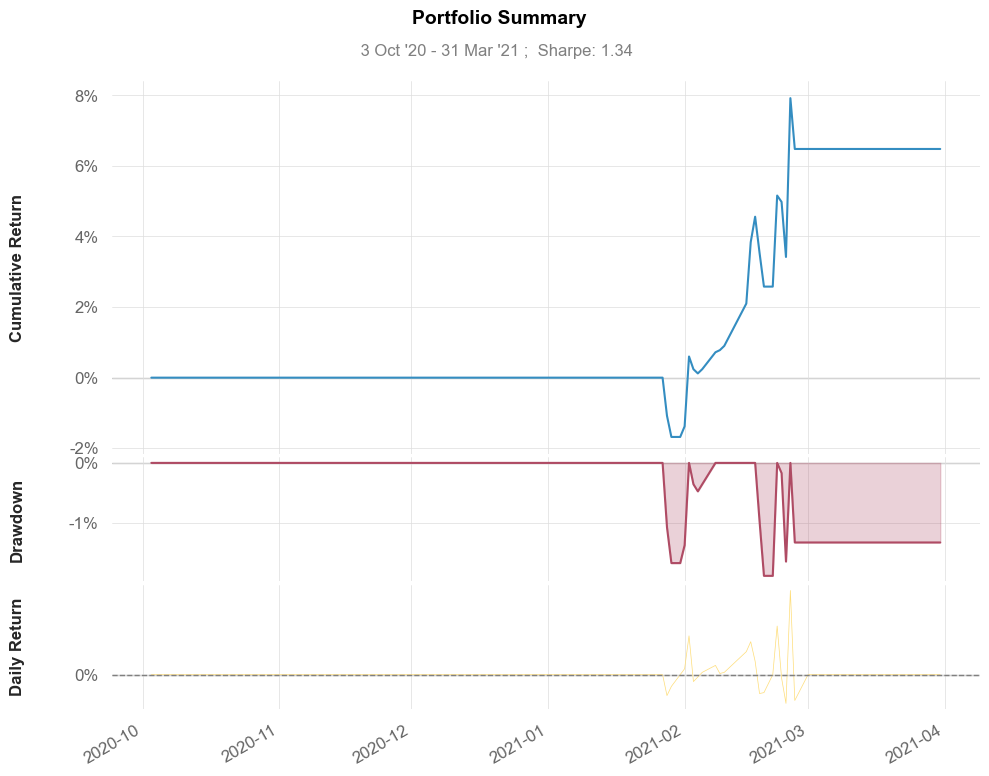

In [64]:
%matplotlib inline
from backtrader_plotly.plotter import BacktraderPlotly
from backtrader_plotly.scheme import PlotScheme


for stock, (strategy, cerebro) in runs.items():
    print(stock)
    print(get_strategy_stats(strategy))
    show_movements(cerebro, plot_tomorrow_forecast=True).show()
    plot_strategy_result(strategy)

## Narrower Bollinger Bands

We observed that the number of transactions is actually very limited. We can change this by narrowing the bands and making the prediction window shorter:

In [67]:
runs_narrow = {
    stock: run_strategy(data, BollingerBandStrategy, enable_log=False, period=10, devfactor=1)
    for stock, data in dfs.items()
}

stats = {
    stock: get_strategy_stats(strategy)
    for stock, (strategy, cerebro) in runs_narrow.items()
}

df_stats_narrow = pd.DataFrame(stats).T

go.Figure(
    data=[
        go.Bar(x=df_stats_narrow.index, y=df_stats_narrow["Profit"] * DEFAULT_CASH, name="Profit"),
        go.Bar(x=df_stats_narrow.index, y=df_stats_narrow["Max Drawdown"] * DEFAULT_CASH, name="Max Drawdown")
    ],
    layout=dict(
        height=500,
        yaxis_title="Dollars"
    )
)

Here we notice that the number of stocks where we made some operation increased, and in two of them, the profit was quite good. We can compare the profits of both types of Bollinger bands (standard and narrow)

In [68]:
go.Figure(
    data=[
        go.Bar(x=df_stats.index, y=df_stats["Profit"] * DEFAULT_CASH, name="Profit"),
        go.Bar(x=df_stats_narrow.index, y=df_stats_narrow["Profit"] * DEFAULT_CASH, name="Profit Narrow"),
    ],
    layout=dict(
        height=500,
        yaxis_title="Dollars"
    )
)

With a narrower band (more frequent operations) it seems the frequency of operations is higher and hence there are profits there where there were non with a wider band. However, the big profits we saw before are reduced.

Let's take a look at the graphs and see what happened:

Russia - Sberbank Rossii PAO (S
{'Sharpe Ratio': -0.08004971882332103, 'Profit': -0.0018382000000004561, 'Max Drawdown': -0.027099800000000118}


Turkey - Koc Holding AS (KCHOL)
{'Sharpe Ratio': 0.38992632645184966, 'Profit': 0.016681599999999852, 'Max Drawdown': -0.032340000000000146}


Egypt - Medinet Nasr Housing (M
{'Sharpe Ratio': 0.3224628407237632, 'Profit': 0.008593299999999804, 'Max Drawdown': -0.03816503661196746}


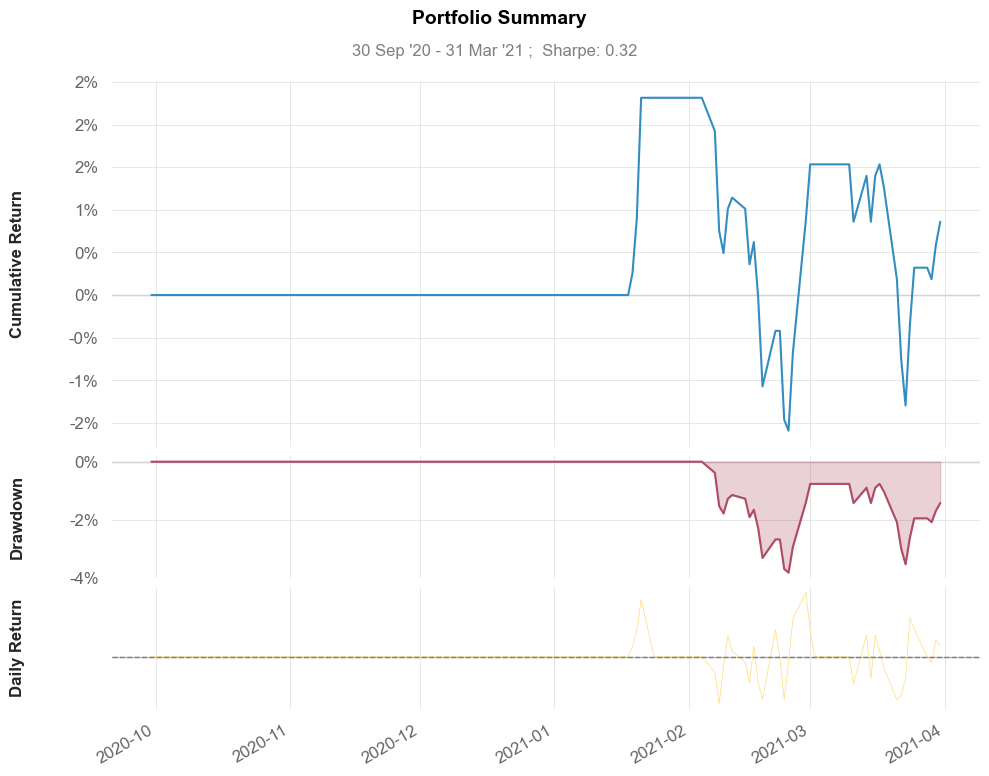

Brazil - Minerva SABrazil (BEEF
{'Sharpe Ratio': 0.7703871019413411, 'Profit': 0.03171609999999947, 'Max Drawdown': -0.05016670000000023}


Argentina - Pampa Energia SA (P
{'Sharpe Ratio': 1.077260201472442, 'Profit': 0.04471100000000039, 'Max Drawdown': -0.041132592898599385}


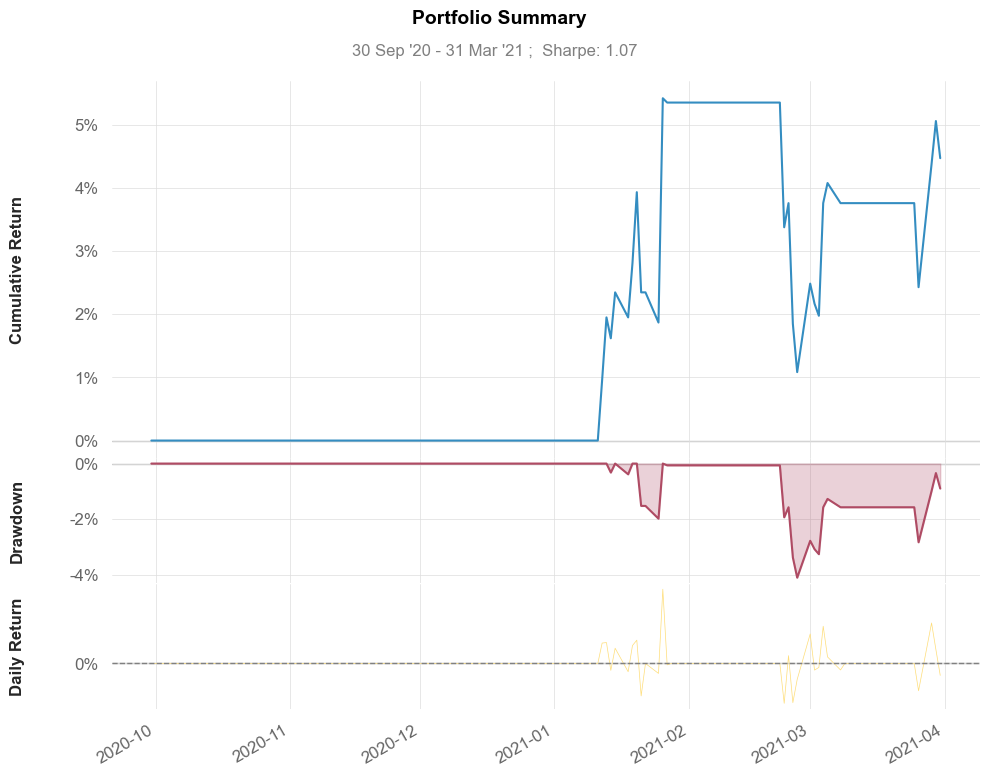

Colombia - Cementos Argos SA (C
{'Sharpe Ratio': -0.6773372045791739, 'Profit': -0.021600000000000508, 'Max Drawdown': -0.08301306687163756}


South Africa - Impala Platinum 
{'Sharpe Ratio': 1.2200170682572764, 'Profit': 0.03285000000000049, 'Max Drawdown': -0.016437660027754486}


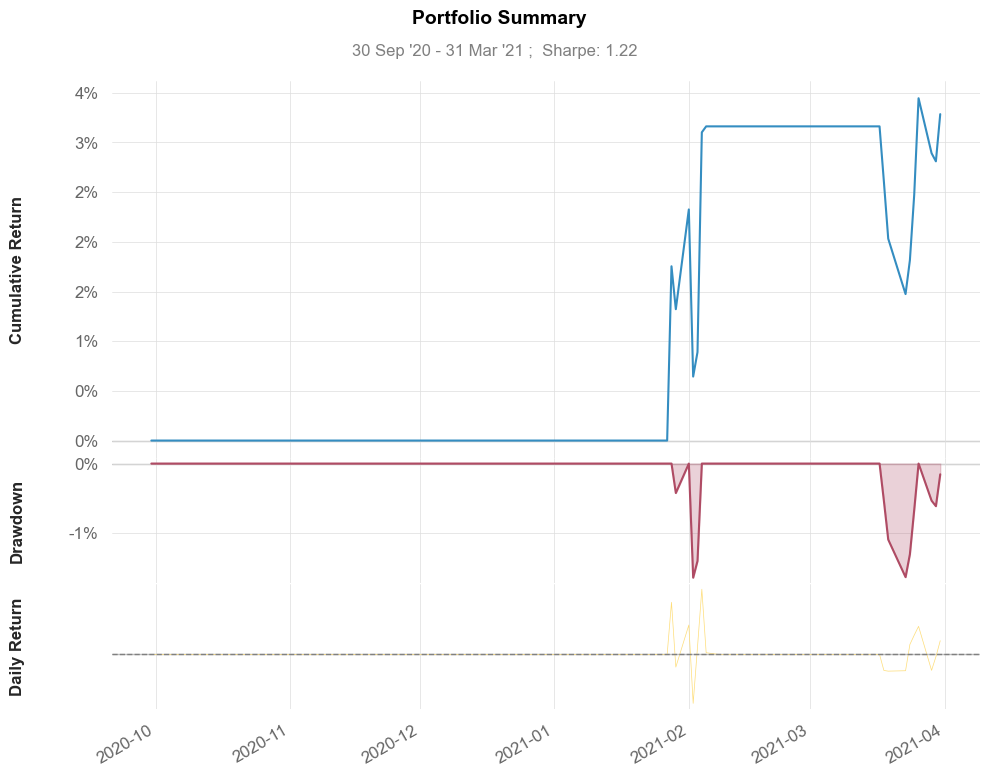

South Korea - Dongkuk Steel Mil
{'Sharpe Ratio': -0.8494947538767049, 'Profit': -0.03100000000000014, 'Max Drawdown': -0.058764940239043884}


In [69]:
%matplotlib inline
for stock, (strategy, cerebro) in runs_narrow.items():
    print(stock)
    print(get_strategy_stats(strategy))
    show_movements(cerebro, plot_tomorrow_forecast=True).show()
    plot_strategy_result(strategy)

# Conclusion

In this project 8 different stock signals were modelled with ARIMA model and other from the same family (SARIMA, SARIMAX), and with Simple Exponential Smoothing model.

These models were used to forecast the stock prices with one day in advance. In general, the predicted price for tomorrow is very similar to today's price.

The Expoinential Smothing model was used in conjunction with a Bollinger Band indicator to create a trading strategy where each time the predicted price for next day goes below the bottom Bollinger band, we create a sell signal, and we sell the moment the price goes above the top band.

Two different widths for the Bollinger bands were used.

In general, a narrow band creates more frequent trades and hence the profits can be more consistent in most of stocks.